In [1]:
from angcal import MythenDetectorSpecifications, FlatField, AngleCalibration, EpicsMythenFileReader, MythenFrame

from pathlib import Path
import os
import numpy as np 

In [2]:
def data_path():
    return Path("/home/mazzol_a/Documents/VariaMay2025/Antonio20250512/AngularConversionTestData/")
def env_data_path():
    env_value = os.environ.get("ANGCAL_TEST_DATA")
    if not env_value:
        raise RuntimeError("Environment variable AARE_TEST_DATA is not set or is empty")

    return Path(env_value)

In [ ]:
import matplotlib.pyplot as plt

def plot(array : np.array, x=None): 
    if x is not None:
        plt.plot(x, array)
    else:
        plt.plot(np.arange(0, array.size,1), array)
    plt.show()

def plot_excluding_channels(array: np.array, channels_to_exclude: np.array, x = None):
    good_channels = np.logical_not(channels_to_exclude)
    if x is not None:
        plt.plot(x[good_channels], array[good_channels])
    else:
        plt.plot(np.arange(0, array.size,1)[good_channels], array[good_channels])
    plt.show()

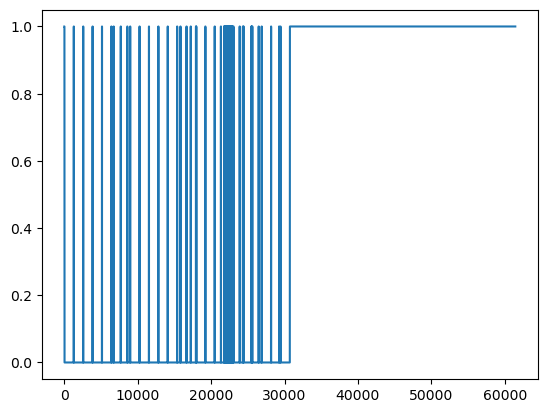

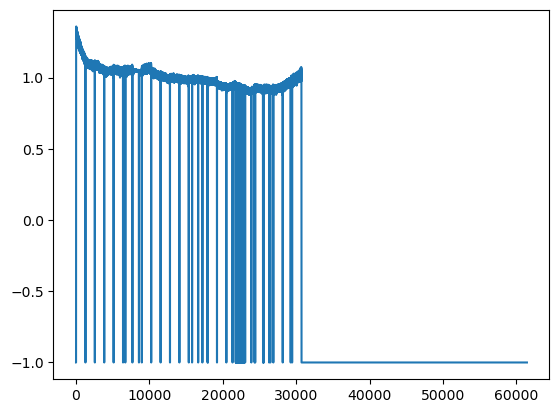

In [4]:


mythendetectorspecifications = MythenDetectorSpecifications() 

#bad_channels = np.loadtxt(data_path() / "bc2023_003_RING.chans", dtype=bool) 

mythendetectorspecifications.read_bad_channels_from_file(str(data_path() / "bc2023_003_RING.chans"))

bad_channels = mythendetectorspecifications.bad_channels

plot(bad_channels)

flatfield = FlatField(mythendetectorspecifications)

normalized_flatfield = np.loadtxt(data_path() / "Flatfield_E17p5keV_T12500eV_up_AUGCAL2_Sep2023_open_WS_C_X_X.raw", dtype=np.double, usecols=[1,2])

flatfield.inverse_normalized_flatfield = 1./normalized_flatfield


plot(flatfield.inverse_normalized_flatfield[:,0])


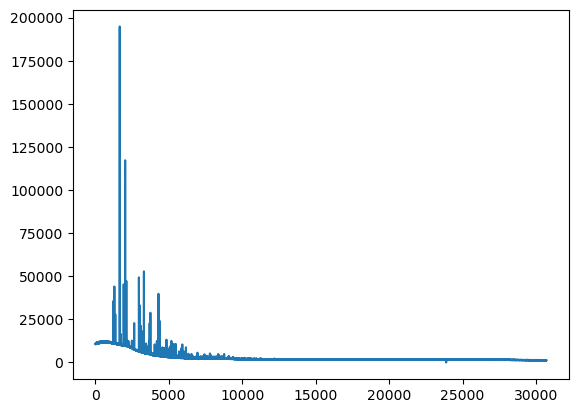

In [ ]:
mythenfilereader = EpicsMythenFileReader()
frame = mythenfilereader.read_frame(str(data_path() / "Fructose_0p2_60_0063.h5")) #TODO how to pass Posix path to pybind

photon_counts = frame.photon_counts 

plot_excluding_channels(photon_counts, bad_channels)


In [6]:
anglecalibration = AngleCalibration(mythendetectorspecifications, flatfield, mythenfilereader)

anglecalibration.read_initial_calibration_from_file(str(data_path() / "Angcal_2E_Feb2023_P29.off"))

In [7]:
redistributed_photon_counts = anglecalibration.redistribute_photon_counts_to_fixed_angle_width_bins(frame)

In [8]:
angle = MythenDetectorSpecifications.min_angle
print(anglecalibration.histogram_bin_width)

0.0036


In [ ]:
bin_indices = np.arange(0, redistributed_photon_counts.size,1)
bin_to_diffraction_angle = lambda bin_index : bin_index * anglecalibration.histogram_bin_width + mythendetectorspecifications.min_angle 

bin_in_degrees = np.apply_along_axis(bin_to_diffraction_angle, 0, bin_indices)

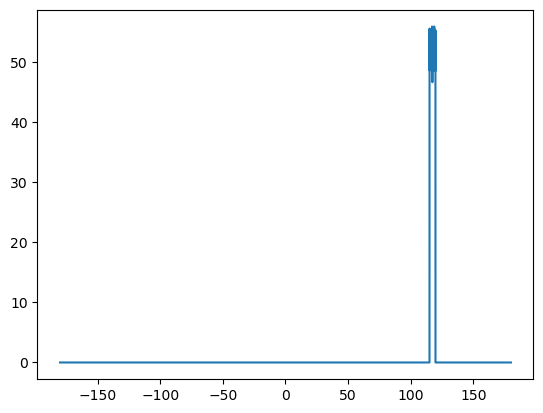

In [ ]:
zero_channels = redistributed_photon_counts == 0
plot_excluding_channels(redistributed_photon_counts, zero_channels, bin_in_degrees)

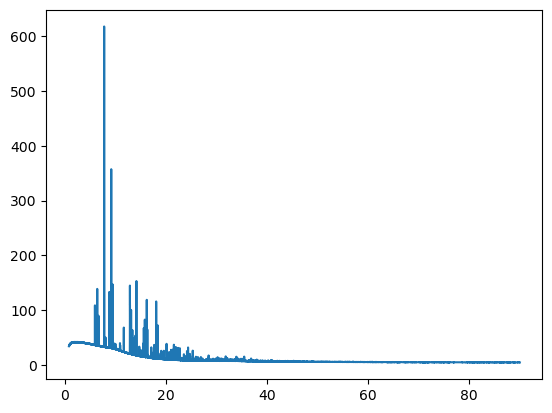

In [17]:
actual_diffraction_pattern = np.loadtxt(data_path() / "Fructose_0p2_60_m_WAXS.xye", dtype=np.double)

plot(actual_diffraction_pattern[:,1], actual_diffraction_pattern[:,0])